## 여러 정리되지 않은 생각들
- 변수들의 n차식 그리고 서로 곱(나누는)는 비선형으로 한번해보기
- 혈압 처방을 받았다면 혈압을 통제하고 있을건데 그러면 몸무게나 다른 팩트들도 정상화 되나?
- 그냥 혈압만 약에대해 통제된다 했을때 국민건강보험공단 데이터에서 고혈압 환자들을 어떻게 구분할까? : 일단, 고협압 환자들이 거의 없을꺼같은 젊은층에서 모델링
- 근데또 혈압은 나이에 따라 (몸무게도 마찬가지) 달라지는데... 

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

# 상관계수
from scipy import stats

# model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.metrics import confusion_matrix


## I.데이터 불러오기&전처리

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ls -l '/content/drive/MyDrive/Colab Notebooks/datasets/health_care/NHIS_OPEN_GJ_2017_v1.1.csv'

-rw------- 1 root root 108444299 Oct  7 01:05 '/content/drive/MyDrive/Colab Notebooks/datasets/health_care/NHIS_OPEN_GJ_2017_v1.1.csv'


In [6]:
DF = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/health_care/NHIS_OPEN_GJ_2017_v1.1.csv', encoding='cp949')

DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 34 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   기준년도          1000000 non-null  int64  
 1   가입자일련번호       1000000 non-null  int64  
 2   성별코드          1000000 non-null  int64  
 3   연령대코드(5세단위)   1000000 non-null  int64  
 4   시도코드          1000000 non-null  int64  
 5   신장(5Cm단위)     1000000 non-null  int64  
 6   체중(5Kg단위)     1000000 non-null  int64  
 7   허리둘레          999734 non-null   float64
 8   시력(좌)         999817 non-null   float64
 9   시력(우)         999811 non-null   float64
 10  청력(좌)         999842 non-null   float64
 11  청력(우)         999844 non-null   float64
 12  수축기혈압         999981 non-null   float64
 13  이완기혈압         999982 non-null   float64
 14  식전혈당(공복혈당)    999958 non-null   float64
 15  총콜레스테롤        999957 non-null   float64
 16  트리글리세라이드      999955 non-null   float64
 17  HDL콜레스테롤      999956 non-nul

In [7]:
# null 값 확인
DF.isnull().sum()

기준년도                  0
가입자일련번호               0
성별코드                  0
연령대코드(5세단위)           0
시도코드                  0
신장(5Cm단위)             0
체중(5Kg단위)             0
허리둘레                266
시력(좌)               183
시력(우)               189
청력(좌)               158
청력(우)               156
수축기혈압                19
이완기혈압                18
식전혈당(공복혈당)           42
총콜레스테롤               43
트리글리세라이드             45
HDL콜레스테롤             44
LDL콜레스테롤           2912
혈색소                  52
요단백                4592
혈청크레아티닌              43
(혈청지오티)AST           41
(혈청지오티)ALT           42
감마지티피                42
흡연상태                144
음주여부                536
구강검진수검여부              0
치아우식증유무         1000000
결손치유무           1000000
치아마모증유무         1000000
제3대구치(사랑니)이상    1000000
치석               621422
데이터공개일자               0
dtype: int64

In [8]:
# 열 삭제하기 (시력)(청력)(구강건강관련) ,기준년도,가입자일년번호, 데이터공개일자, *일단=(혈청지오티)AST 등4개

DF = DF.drop(columns=['기준년도','가입자일련번호','시력(좌)','시력(우)','청력(좌)','청력(우)','구강검진수검여부','치아우식증유무','결손치유무','치아마모증유무','제3대구치(사랑니)이상','치석','데이터공개일자','(혈청지오티)AST','(혈청지오티)ALT','감마지티피'])

In [9]:
#결측치 제거
DF.dropna(inplace = True)

In [10]:
# 음주여부 Y=1,N=0
DF = DF.replace({'Y':1.0,'N':0.0})

In [11]:
# 변수명 정의
sex = DF['성별코드']
age = DF['연령대코드(5세단위)']
city = DF['시도코드']
ht = DF['신장(5Cm단위)']
wt = DF['체중(5Kg단위)']
waist = DF['허리둘레']
sbp = DF['수축기혈압']
dbp = DF['이완기혈압']
fbs = DF['식전혈당(공복혈당)']
tchol = DF['총콜레스테롤']
tg = DF['트리글리세라이드']
hdl = DF['HDL콜레스테롤']
ldl = DF['LDL콜레스테롤']
hgb = DF['혈색소']
upro = DF['요단백']
cr = DF['혈청크레아티닌']
smoking = DF['흡연상태']
alcohol = DF['음주여부']

In [12]:
# 데이터 프레임 변수명 전환
DF = DF.rename(columns={'성별코드':'sex', '연령대코드(5세단위)':'age','시도코드':'city','신장(5Cm단위)':'ht','체중(5Kg단위)':'wt','허리둘레':'waist','수축기혈압':'sbp','이완기혈압':'dbp','식전혈당(공복혈당)':'fbs','총콜레스테롤':'tchol','트리글리세라이드':'tg','HDL콜레스테롤':'hdl','LDL콜레스테롤':'ldl','혈색소':'hgb','요단백':'upro','혈청크레아티닌':'cr','흡연상태':'smoking','음주여부':'alcohol'})

In [13]:
# 정수 실수로 전환
DF['sex'] = pd.to_numeric(DF['sex'], downcast='float')
DF['age'] = pd.to_numeric(DF['age'], downcast='float')
DF['city'] = pd.to_numeric(DF['city'], downcast='float')
DF['ht'] = pd.to_numeric(DF['ht'], downcast='float')
DF['wt'] = pd.to_numeric(DF['wt'], downcast='float')
DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 991608 entries, 0 to 999999
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      991608 non-null  float32
 1   age      991608 non-null  float32
 2   city     991608 non-null  float32
 3   ht       991608 non-null  float32
 4   wt       991608 non-null  float32
 5   waist    991608 non-null  float64
 6   sbp      991608 non-null  float64
 7   dbp      991608 non-null  float64
 8   fbs      991608 non-null  float64
 9   tchol    991608 non-null  float64
 10  tg       991608 non-null  float64
 11  hdl      991608 non-null  float64
 12  ldl      991608 non-null  float64
 13  hgb      991608 non-null  float64
 14  upro     991608 non-null  float64
 15  cr       991608 non-null  float64
 16  smoking  991608 non-null  float64
 17  alcohol  991608 non-null  float64
dtypes: float32(5), float64(13)
memory usage: 124.8 MB


In [14]:
#시간이 너무 많이 걸림
# sns.pairplot(DF)  
# plt.show()

In [15]:
fbs.mean()

100.42426644399804

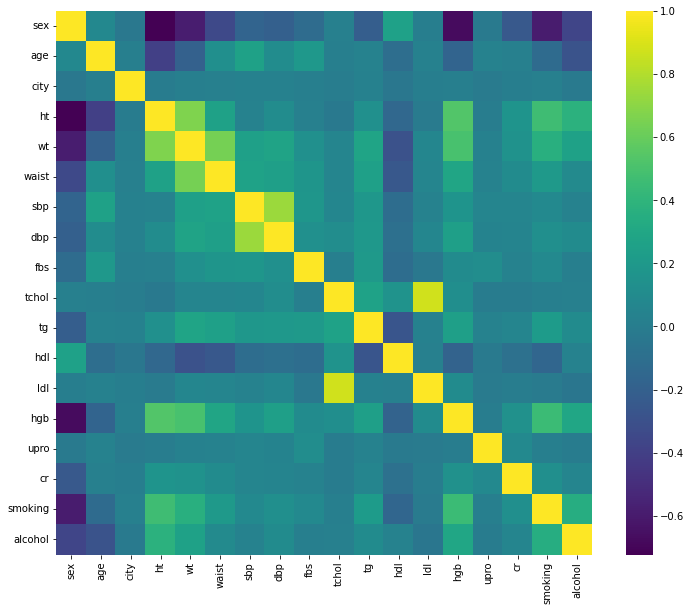

In [16]:
#전체 상관계수 분포
plt.figure(figsize=(12,10))
corr = DF.corr()
sns.heatmap(corr, cmap='viridis')
plt.show()

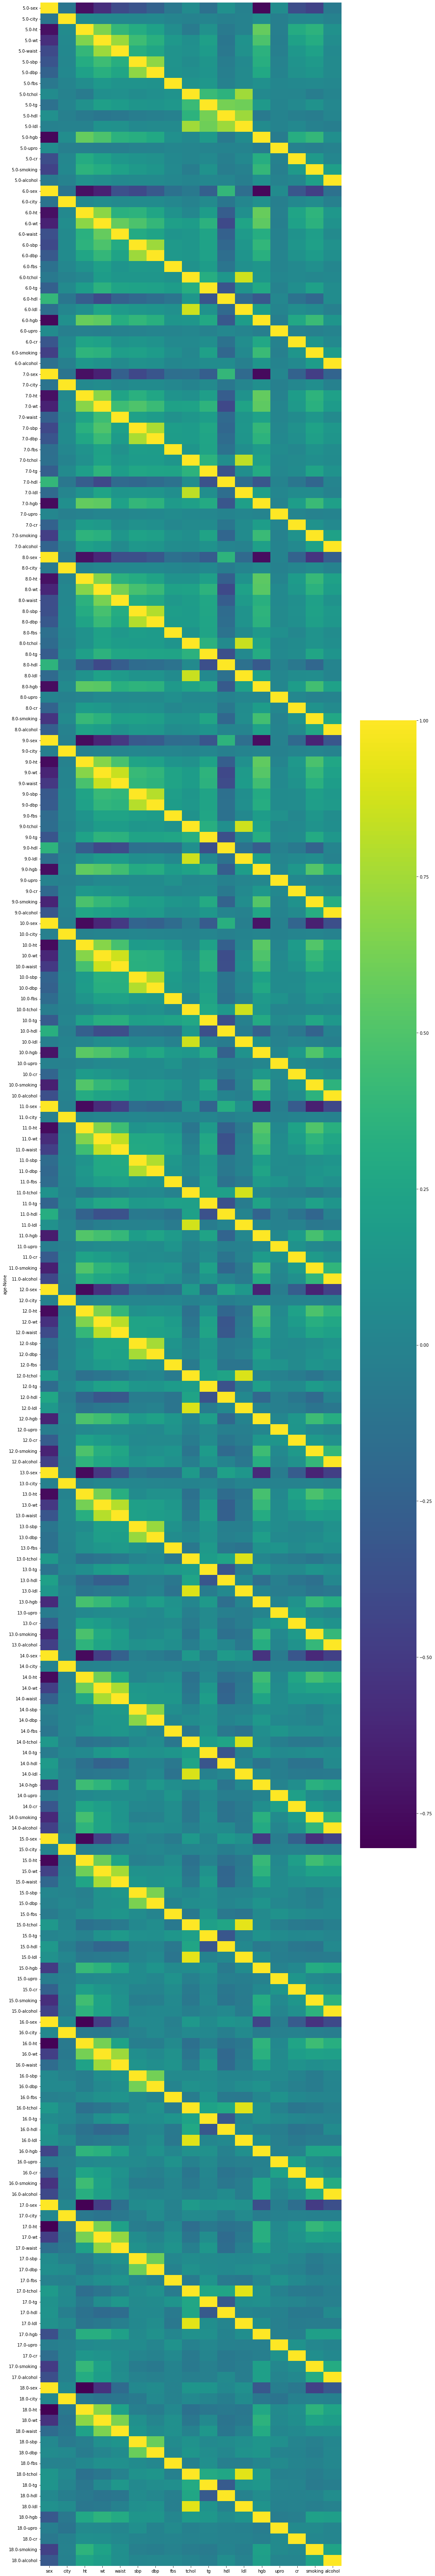

In [17]:
# 연령대별로 groupby
plt.figure(figsize=(16,112))
corr_age = DF.groupby('age').corr()
sns.heatmap(corr_age, cmap='viridis')
plt.show()

## II.데이터 전처리


### 1) bmi, absi 추가하기

In [190]:
# 추가 해야 할 항목들 bmi, absi (A Body Shape Index)
DF['bmi'] = DF['wt']/((DF['ht']/100)**2)
DF['absi'] = (DF['waist']*0.3937)/(DF['bmi']**(2/3)*(DF['ht']/100)**(1/2))

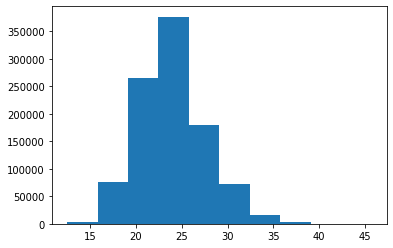

In [191]:
# bmi 분포 확인하기
plt.hist(DF['bmi'])
plt.show()

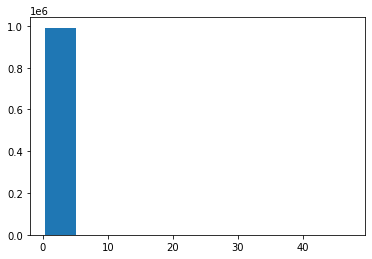

In [192]:
# absi 분포 확인하기
plt.hist(DF['absi'])
plt.show()

In [193]:
DF['absi'].describe()

count    991608.000000
mean          3.034001
std           0.331888
min           0.356442
25%           2.898464
50%           3.026466
75%           3.157905
max          47.187376
Name: absi, dtype: float64

- absi 이상데이터 확인 
- 대략 5이상 불가

### 2) outlier 처리하기

- IQR 3배 기준 밖의 데이터를 outlier로 처리한다
- q25% -(q75-q25)*3
- q75% +(q75-q25)*3

In [111]:
# IQR3 배기준으로 잘라야되는 기준
columns = ['ht','wt','waist','sbp','dbp','fbs','tchol','tg','hdl','ldl','hgb','cr','bmi','absi']

for i in columns:
    
    print('=======', i, '=======')
    
    q25, q75 = np.quantile(DF[i], 0.25), np.quantile(DF[i], 0.75)
    IQR = q75 - q25
    
    lower = q25 - IQR*3
    upper = q75 + IQR*3
    
    print('lower :', lower)
    print('upper :', upper, '\n')

======= ht =======
lower : 110.0
upper : 215.0 

======= wt =======
lower : 10.0
upper : 115.0 

======= waist =======
lower : 32.999999999999986
upper : 128.9 

======= sbp =======
lower : 55.0
upper : 188.0 

======= dbp =======
lower : 34.0
upper : 118.0 

======= fbs =======
lower : 37.0
upper : 156.0 

======= tchol =======
lower : 19.0
upper : 369.0 

======= tg =======
lower : -185.0
upper : 417.0 

======= hdl =======
lower : -14.0
upper : 126.0 

======= ldl =======
lower : -49.0
upper : 273.0 

======= hgb =======
lower : 6.599999999999996
upper : 22.000000000000004 

======= cr =======
lower : -0.20000000000000018
upper : 1.9000000000000001 

======= bmi =======
lower : 8.082826614379883
upper : 39.35310173034668 

======= absi =======
lower : 13.678339452528608
upper : 25.395086070461552 



In [125]:
columns = ['ht','wt','waist','sbp','dbp','fbs','tchol','tg','hdl','ldl','hgb','cr']

for i in columns:
    
    
    q25, q75 = np.quantile(DF[i], 0.25), np.quantile(DF[i], 0.75)
    IQR = q75 - q25
    
    lower = q25 - IQR*3
    upper = q75 + IQR*3
    
    DF_1_1 = DF.drop(DF.loc[(DF[i]>upper)|(DF[i]<lower)].index)
    print('완료 :', i)


    upperN = (DF[i]>upper).sum()
    lowerN = (DF[i]<lower).sum()
    print('outlier :' , lowerN + upperN)

print('outlier가 중복될 수 있음')
DF_1_1.info()

완료 : ht
outlier : 0
완료 : wt
outlier : 368
완료 : waist
outlier : 95
완료 : sbp
outlier : 686
완료 : dbp
outlier : 999
완료 : fbs
outlier : 27738
완료 : tchol
outlier : 498
완료 : tg
outlier : 16946
완료 : hdl
outlier : 613
완료 : ldl
outlier : 403
완료 : hgb
outlier : 306
완료 : cr
outlier : 2086
outlier가 중복될 수 있음
<class 'pandas.core.frame.DataFrame'>
Int64Index: 989522 entries, 0 to 999999
Data columns (total 20 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      989522 non-null  float32
 1   age      989522 non-null  float32
 2   city     989522 non-null  float32
 3   ht       989522 non-null  float32
 4   wt       989522 non-null  float32
 5   waist    989522 non-null  float64
 6   sbp      989522 non-null  float64
 7   dbp      989522 non-null  float64
 8   fbs      989522 non-null  float64
 9   tchol    989522 non-null  float64
 10  tg       989522 non-null  float64
 11  hdl      989522 non-null  float64
 12  ldl      989522 non-null  float64
 13  hgb

- absi 는 이상치가 위로 300짜리가 존재해 평균을 많이 올려서 아웃레이어 아래에 정상치가 많이 잡혀서 위쪽만 자름

In [126]:
columns2 = ['bmi','absi']
for j in columns2:
    
    q25, q75 = np.quantile(DF_1_1[j], 0.25), np.quantile(DF_1_1[j], 0.75)
    IQR = q75 - q25
    
    upper = q75 + IQR*3
    
    DF_1 = DF_1_1.drop(DF_1_1.loc[(DF_1_1[j]>upper)].index)
    print('완료 :', j)


    upperN = (DF_1_1[j]>upper).sum()
    print('outlier :' , upperN)
print('outlier가 중복될 수 있음')
DF_1.info()

완료 : bmi
outlier : 344
완료 : absi
outlier : 556
outlier가 중복될 수 있음
<class 'pandas.core.frame.DataFrame'>
Int64Index: 988966 entries, 0 to 999999
Data columns (total 20 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      988966 non-null  float32
 1   age      988966 non-null  float32
 2   city     988966 non-null  float32
 3   ht       988966 non-null  float32
 4   wt       988966 non-null  float32
 5   waist    988966 non-null  float64
 6   sbp      988966 non-null  float64
 7   dbp      988966 non-null  float64
 8   fbs      988966 non-null  float64
 9   tchol    988966 non-null  float64
 10  tg       988966 non-null  float64
 11  hdl      988966 non-null  float64
 12  ldl      988966 non-null  float64
 13  hgb      988966 non-null  float64
 14  upro     988966 non-null  float64
 15  cr       988966 non-null  float64
 16  smoking  988966 non-null  float64
 17  alcohol  988966 non-null  float64
 18  bmi      988966 non-null  float32
 19  

count    988966.000000
mean         19.555960
std           1.281928
min           2.299630
25%          18.695020
50%          19.525626
75%          20.366799
max          25.388799
Name: absi, dtype: float64


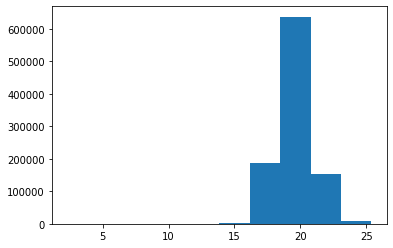

In [130]:
# 더블체크
print(DF_1['absi'].describe())
# absi 분포 확인하기
plt.hist(DF_1['absi'])
plt.show()

In [131]:
DF_1['absi'].head()

0    20.002166
1    19.871241
2    19.727486
3    19.846367
4    20.124589
Name: absi, dtype: float64

In [132]:
DF_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 988966 entries, 0 to 999999
Data columns (total 20 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      988966 non-null  float32
 1   age      988966 non-null  float32
 2   city     988966 non-null  float32
 3   ht       988966 non-null  float32
 4   wt       988966 non-null  float32
 5   waist    988966 non-null  float64
 6   sbp      988966 non-null  float64
 7   dbp      988966 non-null  float64
 8   fbs      988966 non-null  float64
 9   tchol    988966 non-null  float64
 10  tg       988966 non-null  float64
 11  hdl      988966 non-null  float64
 12  ldl      988966 non-null  float64
 13  hgb      988966 non-null  float64
 14  upro     988966 non-null  float64
 15  cr       988966 non-null  float64
 16  smoking  988966 non-null  float64
 17  alcohol  988966 non-null  float64
 18  bmi      988966 non-null  float32
 19  absi     988966 non-null  float64
dtypes: float32(6), float64(14)

## III.스케일링
- DF_1 스케일링 없는 데이터
- DF_s 정규화한 데이터
- DF_n 표준화한 데이터

In [133]:
# 데이터 프레임 분리
sex = DF_1['sex']
age = DF_1['age']
city = DF_1['city']
ht = DF_1['ht']
wt = DF_1['wt']
waist = DF_1['waist']
sbp = DF_1['sbp']
dbp = DF_1['dbp']
fbs = DF_1['fbs']
tchol = DF_1['tchol']
tg = DF_1['tg']
hdl = DF_1['hdl']
ldl = DF_1['ldl']
hgb = DF_1['hgb']
upro = DF_1['upro']
cr = DF_1['cr']
smoking = DF_1['smoking']
alcohol = DF_1['alcohol']
bmi = DF_1['bmi']
absi = DF_1['absi']

In [134]:
# 스켈링 하지 말아야 될 변수들
DF_s = DF_1[['sex','age','city','upro','smoking','alcohol']]
DF_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 988966 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      988966 non-null  float32
 1   age      988966 non-null  float32
 2   city     988966 non-null  float32
 3   upro     988966 non-null  float64
 4   smoking  988966 non-null  float64
 5   alcohol  988966 non-null  float64
dtypes: float32(3), float64(3)
memory usage: 41.5 MB


In [135]:
# 스켈링 해야할 변수들
columns = ['ht','wt','waist','sbp','dbp','fbs','tchol','tg','hdl','ldl','hgb','cr','bmi','absi']

for i in columns :

    DF_s[i] = StandardScaler().fit_transform(DF_1[[i]])

DF_s.head()


,sex,age,city,upro,smoking,alcohol,ht,wt,waist,sbp,dbp,fbs,tchol,tg,hdl,ldl,hgb,cr,bmi,absi
0,1.0,8.0,43.0,1.0,1.0,1.0,0.835399,0.935809,0.921468,-0.165930,0.399669,-0.057786,-0.067703,-0.392115,-0.519582,0.361190,1.812986,0.744610,0.578495,0.348075
1,1.0,7.0,11.0,1.0,3.0,0.0,1.912949,1.335502,0.817146,0.522591,0.602030,0.232840,0.839795,-0.108489,-0.113495,0.976367,0.990233,0.243770,0.219823,0.245943
2,1.0,9.0,41.0,1.0,1.0,0.0,0.296624,0.935809,1.025789,-0.165930,-0.612132,-0.099304,-1.545627,-0.274752,-0.925668,-1.092864,0.990233,0.243770,1.032929,0.133803
3,1.0,11.0,48.0,1.0,1.0,0.0,1.374174,1.335502,1.025789,1.555372,1.107931,-0.223858,0.139725,-0.255192,1.104765,-0.253987,2.129429,1.245450,0.627134,0.226539
4,1.0,11.0,30.0,1.0,1.0,0.0,0.296624,-0.263272,-0.121747,1.073408,0.602030,0.025250,0.087868,-0.274752,0.234579,0.109527,-0.275539,-0.257071,-0.535204,0.443573


In [136]:
DF_n = DF_1[['sex','age','city','upro','smoking','alcohol']]
columns = ['ht','wt','waist','sbp','dbp','fbs','tchol','tg','hdl','ldl','hgb','cr','bmi','absi']

for i in columns :

    DF_n[i] = MinMaxScaler().fit_transform(DF_1[[i]])

DF_n.head()

,sex,age,city,upro,smoking,alcohol,ht,wt,waist,sbp,dbp,fbs,tchol,tg,hdl,ldl,hgb,cr,bmi,absi
0,1.0,8.0,43.0,1.0,1.0,1.0,0.666667,0.434783,0.598540,0.257282,0.313725,0.089480,0.075254,0.009590,0.005796,0.024424,0.670833,0.500000,0.405226,0.766703
1,1.0,7.0,11.0,1.0,3.0,0.0,0.833333,0.478261,0.591241,0.305825,0.326797,0.097944,0.091413,0.012646,0.006659,0.028722,0.616667,0.444444,0.367299,0.761033
2,1.0,9.0,41.0,1.0,1.0,0.0,0.583333,0.434783,0.605839,0.257282,0.248366,0.088271,0.048938,0.010855,0.004933,0.014263,0.616667,0.444444,0.453278,0.754807
3,1.0,11.0,48.0,1.0,1.0,0.0,0.750000,0.478261,0.605839,0.378641,0.359477,0.084643,0.078947,0.011065,0.009249,0.020125,0.691667,0.555556,0.410369,0.759955
4,1.0,11.0,30.0,1.0,1.0,0.0,0.583333,0.304348,0.525547,0.344660,0.326797,0.091898,0.078024,0.010855,0.007399,0.022665,0.533333,0.388889,0.287462,0.772005


## IV.모델링 - 공복혈당 추론하기 - liner regression
- 적은수의 x : 나이, 성별, 키, 몸무게, 허리둘레, 음주, 흠연여부, (혹시 지역)
- 모든가능한 x : 17가지 


+ 1) 자가혈당 측정시 10~15%의 오차가 있다고 한다. (출처:삼성서울벼원 당뇨교육실)
+ 2) 이른 아침 공복 시에는 동맥과 정맥의 혈당 농도 차이는 10정도, 식후에는 20-25 차이가 있다 (네이버: 내과의사 너구리스)

In [137]:
DF_1['fbs'].describe()

count    988966.000000
mean        100.391836
std          24.085975
min          25.000000
25%          88.000000
50%          96.000000
75%         105.000000
max         852.000000
Name: fbs, dtype: float64

In [138]:
# 표준화한 데이터 체크
DF_s['fbs'].describe()

count    9.889660e+05
mean     9.879383e-16
std      1.000001e+00
min     -3.130115e+00
25%     -5.144837e-01
50%     -1.823400e-01
75%      1.913216e-01
max      3.120524e+01
Name: fbs, dtype: float64

### 1)일반 모델 - sklearn의 linearRegression

In [139]:
X = DF_s[['age', 'sex','city','ht','wt','waist','smoking','alcohol']]
y = DF_s['fbs']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)
print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Train Data :  (692276, 8) (692276,)
Test Data :  (296690, 8) (296690,)


In [140]:
fbs_model_1 = LinearRegression()
fbs_model_1.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [141]:
y_hat = fbs_model_1.predict(X_test)

In [142]:
mse1 = mean_squared_error(y_test, y_hat)
np.sqrt(mse1)

0.9657839051005352

### 2) 일반모델 확인 - statsmodels의 linearRegression

In [143]:
train_set, test_set = train_test_split(DF_s,
                                       test_size = 0.3,
                                       random_state = 2045)
train_set.shape, test_set.shape

((692276, 20), (296690, 20))

In [144]:
fbs_model_2 = smf.ols(formula = 'fbs ~ age + sex + city + ht + wt + waist + smoking + alcohol',
                      data = train_set).fit()

In [145]:
y_hat_2 = fbs_model_2.predict(test_set[['age', 'sex','city','ht','wt','waist','smoking','alcohol']])

In [146]:
mse2 = mean_squared_error(test_set.fbs, y_hat_2)
np.sqrt(mse2)


0.9657839051005354

- 1)과2) 당현히 같고 0.96을 거꾸로 실제 값으로 돌려 계산하면 약 23 정도로 평균 100의 혈당치에서 23%의 오차가 남을 알 수 있다.
- std          24.102862 * mse = 23.2


### 2) 2) bmi 와 absi 를 추가해서 시행

In [147]:
train_set, test_set = train_test_split(DF_s,
                                       test_size = 0.3,
                                       random_state = 2045)
train_set.shape, test_set.shape

((692276, 20), (296690, 20))

In [148]:
fbs_model_2_2 = smf.ols(formula = 'fbs ~ age + sex + city + ht + wt + waist + smoking + alcohol+ bmi + absi',
                      data = train_set).fit()

In [149]:
y_hat_2_2 = fbs_model_2_2.predict(test_set[['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi']])

In [150]:
mse2_2 = mean_squared_error(test_set.fbs, y_hat_2_2)
np.sqrt(mse2_2)

0.9657928166438473

### bmi 와 absi 를 추가 했을시 향상한점이 보니나 충분하지 못하다.

### 3) 변수 다항화 - ABSI 모델
- MSE 작을수록 좋은 모델
- A Body Shape Index(ABSI) : ABSI waist/(BMI *2/3) * (ht *1/2) = A * waist X wt^2 : 약간 줄어들고,별차의 없음

In [151]:
fbs_model_3 = smf.ols(formula = 'fbs ~ age + sex + city + ht + wt + waist + smoking + alcohol + absi',
                      data = train_set).fit()

In [152]:
y_hat_3 = fbs_model_3.predict(test_set[['age', 'sex','ht','wt','city','waist','smoking','alcohol','absi']])

In [153]:
mse3 = mean_squared_error(test_set.fbs, y_hat_3)

print(np.sqrt(mse2))
print(np.sqrt(mse3))

0.9657839051005354
0.9658153490091254


### 4) 변수 축소 - 변수 최소화 영향 안미치는 변수 제거

In [154]:
#변수를 최대한 줄인 모델
fbs_model_4 = smf.ols(formula = 'fbs ~ age + ht + wt + waist + smoking + alcohol ',
                      data = train_set).fit()

y_hat_4 = fbs_model_4.predict(test_set[['age', 'sex','ht','wt','city','waist','smoking','alcohol']])

mse4 = mean_squared_error(test_set.fbs, y_hat_4)

print(np.sqrt(mse2))
print(np.sqrt(mse4))

0.9657839051005354
0.9661427198127601


### 5) 변수 다양화 - 내생각 변수 생성

In [155]:
fbs_model_5 = smf.ols(formula = 'fbs ~ age + ht + wt + waist + smoking + alcohol + wt/(waist*ht)',
                      data = train_set).fit()

y_hat_5 = fbs_model_5.predict(test_set[['age', 'sex','ht','wt','city','waist','smoking','alcohol']])

mse5 = mean_squared_error(test_set.fbs, y_hat_5)

print(np.sqrt(mse2))
print(np.sqrt(mse5))

0.9657839051005354
0.9656043237513287


In [156]:
fbs_model_6 = smf.ols(formula = 'fbs ~ age + ht + wt + waist + smoking + alcohol + ht/(waist*wt)',
                      data = train_set).fit()

y_hat_6 = fbs_model_6.predict(test_set[['age', 'sex','ht','wt','city','waist','smoking','alcohol']])

mse6 = mean_squared_error(test_set.fbs, y_hat_6)

print(np.sqrt(mse2))
print(np.sqrt(mse6))

0.9657839051005354
0.9658777587037781


### 6)재미를 위해 x변수 중 하나를 y로, y를 x로

## V. 모델링 - 공복혈당 추론하기 - Decision Tree
- 혈당수치가 연속적을 나와있어 분류모델을 적용하기 위해 레이블을 붙여 넣었음.
- -99 정상, 100-125 당뇨 전단계, 126이상 당뇨
- 만약 레이블이 없다면 최소단위


### 1) 1) 3그룹으로 분류

In [157]:
DF_1['fbs_L'] = np.digitize(DF_1['fbs'], [99,125,999])
DF_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 988966 entries, 0 to 999999
Data columns (total 21 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      988966 non-null  float32
 1   age      988966 non-null  float32
 2   city     988966 non-null  float32
 3   ht       988966 non-null  float32
 4   wt       988966 non-null  float32
 5   waist    988966 non-null  float64
 6   sbp      988966 non-null  float64
 7   dbp      988966 non-null  float64
 8   fbs      988966 non-null  float64
 9   tchol    988966 non-null  float64
 10  tg       988966 non-null  float64
 11  hdl      988966 non-null  float64
 12  ldl      988966 non-null  float64
 13  hgb      988966 non-null  float64
 14  upro     988966 non-null  float64
 15  cr       988966 non-null  float64
 16  smoking  988966 non-null  float64
 17  alcohol  988966 non-null  float64
 18  bmi      988966 non-null  float32
 19  absi     988966 non-null  float64
 20  fbs_L    988966 non-null  

In [158]:
DF_1['fbs_L'].value_counts()

0    587544
1    322119
2     79303
Name: fbs_L, dtype: int64

In [159]:
X = DF_1[['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi']]
y = DF_1['fbs_L']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)
print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Train Data :  (692276, 10) (692276,)
Test Data :  (296690, 10) (296690,)


In [160]:
Model_dt1 = DecisionTreeClassifier(random_state = 2045)
# Model_dt = DecisionTreeClassifier(max_depth = 3,
#                                   random_state = 2045)
Model_dt1.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2045, splitter='best')

In [50]:
# 시간이 오래걸림
# graphviz.Source(export_graphviz(Model_dt1,
#                                 class_names = (['0', '1', '2']),
#                                 feature_names = (['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi']),
#                                 filled = True))

In [161]:
y_hat1 = Model_dt1.predict(X_test)
y_hat1


array([1, 0, 1, ..., 0, 1, 0])

In [162]:
confusion_matrix(y_test, y_hat1)

array([[127158,  41840,   7432],
       [ 60372,  29608,   6557],
       [ 12944,   8442,   2337]])

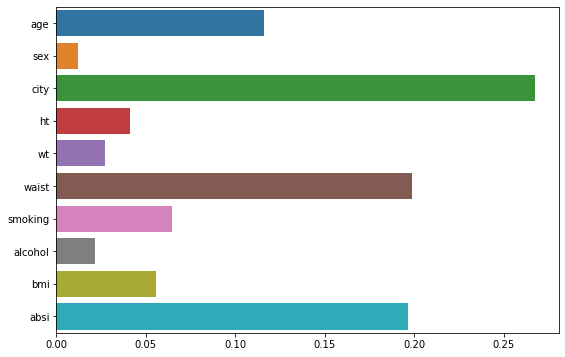

In [163]:
plt.figure(figsize=(9, 6))
sns.barplot(Model_dt1.feature_importances_, ['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi'])
plt.show()

### 1) 2) 변수 최대한 줄여보기, 복합변수는 넣기

In [167]:
X = DF_1[['age', 'sex','smoking','alcohol','bmi','absi']]
y = DF_1['fbs_L']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)
print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)


Model_dt1_2 = DecisionTreeClassifier(random_state = 2045)
# Model_dt1_2 = DecisionTreeClassifier(max_depth = 3,
#                                   random_state = 2045)
Model_dt1_2.fit(X_train, y_train)


y_hat1_2 = Model_dt1_2.predict(X_test)
confusion_matrix(y_test, y_hat1_2)

Train Data :  (692276, 6) (692276,)
Test Data :  (296690, 6) (296690,)


array([[142660,  30872,   2898],
       [ 68219,  25514,   2804],
       [ 14611,   7988,   1124]])

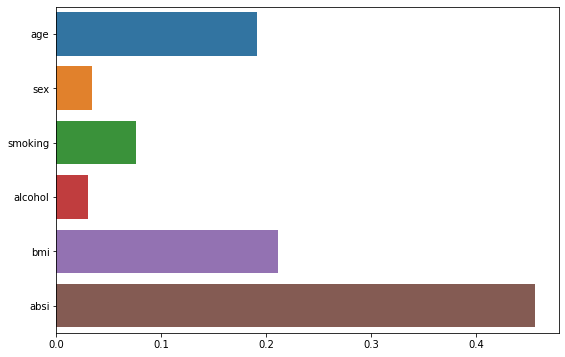

In [169]:
plt.figure(figsize=(9, 6))
sns.barplot(Model_dt1_2.feature_importances_, ['age', 'sex','smoking','alcohol','bmi','absi'])
plt.show()

- 정상 분리는 많아졌으나 중요한 위험군과 당뇨 범위 정확도는 낮아짐

### 2) 1) 2그룹으로 분류 (fbs_L2): 일반+ 위험군 과 당뇨

In [170]:
DF_1['fbs_L2'] = np.digitize(DF_1['fbs'], [125])
DF_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 988966 entries, 0 to 999999
Data columns (total 22 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      988966 non-null  float32
 1   age      988966 non-null  float32
 2   city     988966 non-null  float32
 3   ht       988966 non-null  float32
 4   wt       988966 non-null  float32
 5   waist    988966 non-null  float64
 6   sbp      988966 non-null  float64
 7   dbp      988966 non-null  float64
 8   fbs      988966 non-null  float64
 9   tchol    988966 non-null  float64
 10  tg       988966 non-null  float64
 11  hdl      988966 non-null  float64
 12  ldl      988966 non-null  float64
 13  hgb      988966 non-null  float64
 14  upro     988966 non-null  float64
 15  cr       988966 non-null  float64
 16  smoking  988966 non-null  float64
 17  alcohol  988966 non-null  float64
 18  bmi      988966 non-null  float32
 19  absi     988966 non-null  float64
 20  fbs_L    988966 non-null  

In [171]:
DF_1['fbs_L2'].value_counts()

0    909663
1     79303
Name: fbs_L2, dtype: int64

In [172]:
X = DF_1[['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi']]
y = DF_1['fbs_L2']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)
print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Train Data :  (692276, 10) (692276,)
Test Data :  (296690, 10) (296690,)


In [173]:
Model_dt_2 = DecisionTreeClassifier(random_state = 2045)
# Model_dt_2 = DecisionTreeClassifier(max_depth = 2,
#                                   random_state = 2045)
Model_dt_2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2045, splitter='best')

In [174]:
y_hat2 = Model_dt_2.predict(X_test)
y_hat2


array([0, 1, 0, ..., 0, 0, 0])

In [59]:
# 시간이 많이 걸림
# graphviz.Source(export_graphviz(Model_dt_2,
#                                 class_names = (['0', '1']),
#                                 feature_names = (['age', 'sex','city','ht','wt','waist','smoking','alcohol']),
#                                 filled = True))

In [175]:
confusion_matrix(y_test, y_hat2)

array([[258459,  14508],
       [ 21264,   2459]])

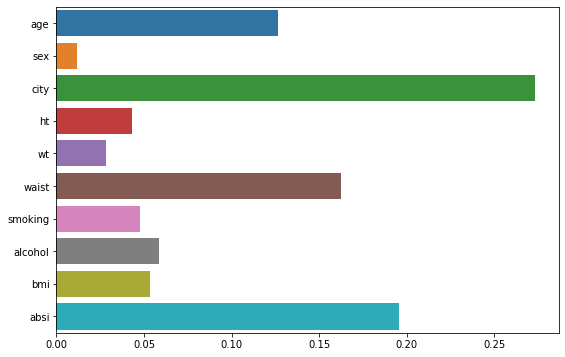

In [176]:
plt.figure(figsize=(9, 6))
sns.barplot(Model_dt_2.feature_importances_, ['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi'])
plt.show()

### 2) 2) 2그룹으로 분류 (fbs_L3) : 일반과 위험+당뇨

In [177]:
DF_1['fbs_L3'] = np.digitize(DF_1['fbs'], [99])
DF_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 988966 entries, 0 to 999999
Data columns (total 23 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      988966 non-null  float32
 1   age      988966 non-null  float32
 2   city     988966 non-null  float32
 3   ht       988966 non-null  float32
 4   wt       988966 non-null  float32
 5   waist    988966 non-null  float64
 6   sbp      988966 non-null  float64
 7   dbp      988966 non-null  float64
 8   fbs      988966 non-null  float64
 9   tchol    988966 non-null  float64
 10  tg       988966 non-null  float64
 11  hdl      988966 non-null  float64
 12  ldl      988966 non-null  float64
 13  hgb      988966 non-null  float64
 14  upro     988966 non-null  float64
 15  cr       988966 non-null  float64
 16  smoking  988966 non-null  float64
 17  alcohol  988966 non-null  float64
 18  bmi      988966 non-null  float32
 19  absi     988966 non-null  float64
 20  fbs_L    988966 non-null  

In [178]:
DF_1['fbs_L3'].value_counts()

0    587544
1    401422
Name: fbs_L3, dtype: int64

In [179]:
X = DF_1[['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi']]
y = DF_1['fbs_L3']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)
print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Train Data :  (692276, 10) (692276,)
Test Data :  (296690, 10) (296690,)


In [180]:
Model_dt_2_2 = DecisionTreeClassifier(random_state = 2045)
# Model_dt_2_2 = DecisionTreeClassifier(max_depth = 2,
#                                   random_state = 2045)
Model_dt_2_2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2045, splitter='best')

In [181]:
y_hat2_2 = Model_dt_2_2.predict(X_test)

confusion_matrix(y_test, y_hat2_2)

array([[124501,  51929],
       [ 70795,  49465]])

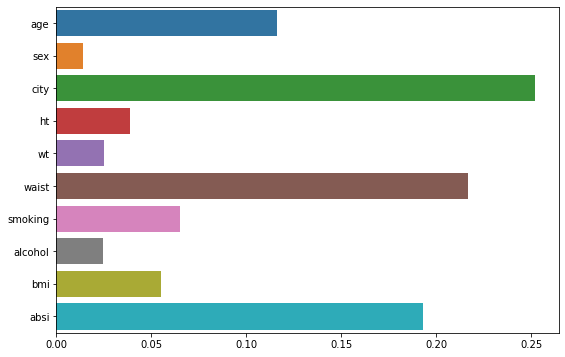

In [182]:
plt.figure(figsize=(9, 6))
sns.barplot(Model_dt_2_2.feature_importances_, ['age', 'sex','city','ht','wt','waist','smoking','alcohol','bmi','absi'])
plt.show()

### 3) 결론
- DT 로 혈당을 측정할때 가지고 있는 변수만 사용하면 높은 정확도를 낼 수 없다
- 당뇨환자만 추출하는 것이 목적이라 정상+위험: 당뇨 그룹으로 나누워도 측정하기가 힘들었다
- 고혈압 판정으로 약복용하여 위험군 수준으로 혈당을 나추었다 가정하여. 정상:위험+당뇨 군으로 나누어 하더라도 정확도 가 높지 않았다

## VI.모델링 - 공복혈당 추론하기 - Decision Tree - 연령대별
- 만약 머신이 약 처방받은 사람의 특징때문에 

## VII. 모델링 - 공복혈당 추론하기 - Random forest

In [185]:
DF_t = DF_1[['age','bmi','absi','fbs_L3']]

In [186]:
DF_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 988966 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   age     988966 non-null  float32
 1   bmi     988966 non-null  float32
 2   absi    988966 non-null  float64
 3   fbs_L3  988966 non-null  int64  
dtypes: float32(2), float64(1), int64(1)
memory usage: 30.2 MB


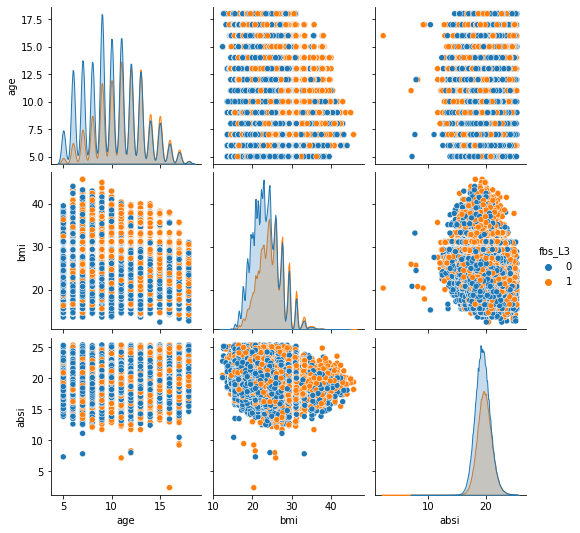

In [187]:
# 7분정도 소요
# sns.pairplot(hue= 'fbs_L3',data = DF_t)
# plt.show()

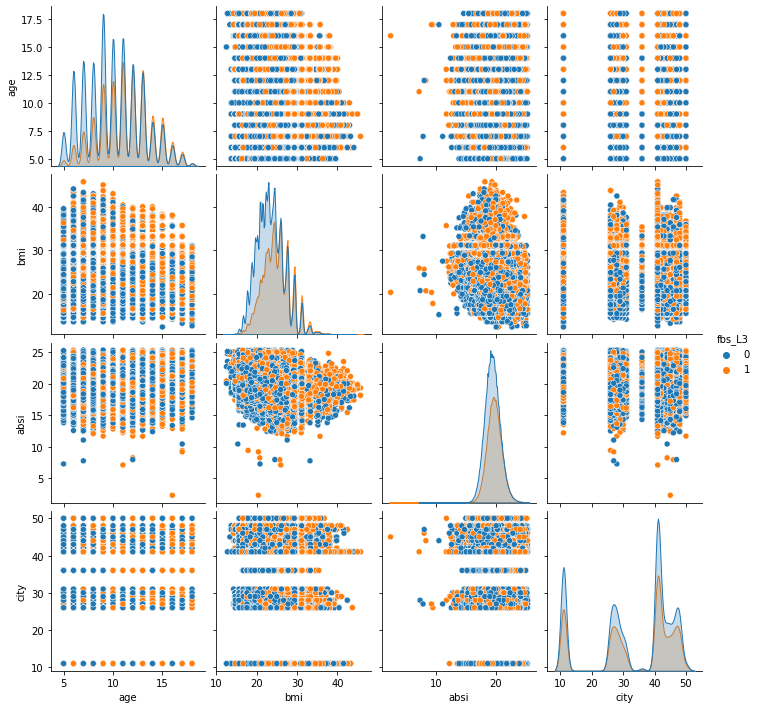

In [189]:
# 14분 소요
# DF_t2 = DF_1[['age','bmi','absi','city','fbs_L3']]
# sns.pairplot(hue= 'fbs_L3',data = DF_t2)
# plt.show()